## Messages
LangChain supports various message types, including 'HumanMessage', 'AIMessage', 'SystemMessage', and 'ToolMessage'. These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call.Let's create a list of messages.
Each message can be supplied with a few things:
- content - content of the message
- name - optionally, a message author
- response_metadata - optionally, a dict of metadata (e.g., often populated by model provider for AIMessages)

In [1]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(
    content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.", name="Lance"))
messages.append(
    AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(
    content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


In [2]:
from langchain_openai import ChatOpenAI
llm: ChatOpenAI = ChatOpenAI(
    base_url="http://127.0.0.1:1234/v1",
    temperature=0,
    api_key="not-needed"
)
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [3]:
result

AIMessage(content="<think>\nOkay, the user wants to know the best place in the US to see orcas. Let me start by recalling where orcas are commonly seen. They're found along the coasts of Alaska, Washington, Oregon, and California. The Pacific Northwest is a hotspot.\n\nI should mention specific locations like the Olympic Peninsula, which has the Olympic National Park. There's also the San Juan Islands in Washington State, known for their orca populations. The Gulf of Alaska is another area with orcas, especially near the Kenai Peninsula.\n\nWait, the user might be interested in both coastal and inland areas. Maybe I should list the top regions and explain why each is good. For example, the Olympic National Park offers diverse wildlife, while the San Juan Islands have more concentrated orca sightings.\n\nI should also consider factors like accessibility, seasonality, and any specific activities they might enjoy. Maybe mention places like the Inside Passage for a scenic drive. Also, note

In [4]:
result.response_metadata

{'token_usage': {'completion_tokens': 1240,
  'prompt_tokens': 64,
  'total_tokens': 1304,
  'completion_tokens_details': None,
  'prompt_tokens_details': None},
 'model_name': 'qwen3-1.7b',
 'system_fingerprint': 'qwen3-1.7b',
 'id': 'chatcmpl-a5nkydi7jia7cmsz2c1jt',
 'finish_reason': 'stop',
 'logprobs': None}

In [5]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


llm_with_tools = llm.bind_tools([multiply])

In [6]:
tool_call = llm_with_tools.invoke(
    [HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])

In [7]:
tool_call.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': '285126909',
  'type': 'tool_call'}]

## Using messages as state

In [ ]:
from langgraph.graph import MessagesState
from typing import Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage
from typing_extensions import TypedDict

# C1
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

# C2 : less verbose than defining a custom TypedDict
class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built
    pass

In [10]:
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(
                        content="I'm looking for information on marine biology.", name="Lance")
                    ]

# New message to add
new_message = AIMessage(
    content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages, new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='39a897d4-aec6-4407-bf20-09efca678771'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='3a4ea5e4-5548-41cb-a9b9-3bde1033e9e3'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='77d44a76-9c80-43bb-99dc-98ddcf62556a')]

## Our graph

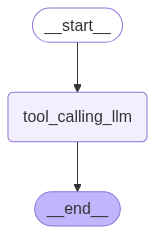

In [11]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Node : đầu vào luôn là dictionary để mình trích xuất "messages"
def tool_calling_llm(state:MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

<think>
Okay, the user said "Hello!" which is a greeting. I need to respond appropriately. Since there's no specific question or request here, I should just greet them back and offer help. Let me check if any functions are needed. The available function is multiply, but they didn't ask for a math problem. So, no function call required. Just a friendly response.
</think>

Hello! How can I assist you today?


In [13]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (553223065)
 Call ID: 553223065
  Args:
    a: 2
    b: 3
